In [1]:
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import sys
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from matplotlib import colormaps
from tqdm.notebook import tqdm
import helpers
import statsmodels.formula.api as smf
from statsmodels.stats.mediation import Mediation
from pyprocessmacro import Process


from mri_data import file_manager as fm

## Load Data

In [16]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/analysis/thalamus/figures_tables/sdmt_regressions")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")
ventricle_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/analysis/paper1/data0/ventricle_volumes.csv",
    index_col="subid",
)

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
sdmt = pd.read_csv("/home/srs-9/Projects/ms_mri/analysis/thalamus/SDMT_sheet.csv", index_col="subid")

df['thalamus_sq'] = (df['thalamus']/df['thalamus'].mean())**2
df = df.join([choroid_volumes, tiv, ventricle_volumes, sdmt['SDMT']])
df['SDMT'] = pd.to_numeric(df['SDMT'], errors='coerce')

df['ventricle_logtrans'] = np.log(df['ventricle_volume'])

df = helpers.get_mri_edss_delta(df)

df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

df_ms = df[df['dz_type2'] == "MS"]
df_ms_z = df_ms.copy()
df_ms_z[numeric_cols] = df_ms_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

colors = helpers.get_colors()

/tmp/ipykernel_221153/3054347294.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['thalamus_sq'] = (df['thalamus']/df['thalamus'].mean())**2
/tmp/ipykernel_221153/3054347294.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ventricle_logtrans'] = np.log(df['ventricle_volume'])
/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

In [3]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas['THALAMUS_1_sq'] = (df_thomas['THALAMUS_1']/df_thomas["THALAMUS_1"].mean())**2
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

df_thomas_left = pd.read_csv(data_dir / "hipsthomas_left_vols.csv", index_col="subid")
df_thomas_left = df_thomas_left.rename(columns=new_colnames)
df_thomas_left_z = df_thomas_left.apply(stats.zscore, nan_policy="omit")

df_thomas_right = pd.read_csv(data_dir / "hipsthomas_right_vols.csv", index_col="subid")
df_thomas_right = df_thomas_right.rename(columns=new_colnames)
df_thomas_right_z = df_thomas_right.apply(stats.zscore, nan_policy="omit")

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)['struct']
# hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

def combine_nuclei2(df):
    df2 = pd.DataFrame()
    df2["anterior"] = df["AV_2"]
    df2["ventral"] = df["VA_4"] + df["VLa_5"] + df["VLP_6"] + df["VPL_7"]
    df2["medial"] = df["MD_Pf_12"] + df["CM_11"]
    df2["posterior"] = df["Pul_8"] + df["LGN_9"] + df["MGN_10"]
    df2["THALAMUS_1"] = df["THALAMUS_1"]
    return df2

df_thomas2 = combine_nuclei2(df_thomas)
grouped_nuclei = df_thomas2.columns[~df_thomas2.columns.isin(["THALAMUS_1"])]
df_thomas2_z = df_thomas2.apply(stats.zscore, nan_policy="omit")
df_thomas2_norm = df_thomas2.apply(lambda col: col / df_thomas["THALAMUS_1"])
df_thomas2_norm_z = df_thomas2_norm.apply(stats.zscore, nan_policy="omit")

## Functions

In [4]:
def plot_moderation(model_data, y_name, x_name, w_name, covariates,
                    xlab_name=None, ylab_name=None, wlab_name=None):
    if xlab_name is None:
        xlab_name = x_name
    if ylab_name is None:
        ylab_name = y_name
    if wlab_name is None:
        wlab_name = w_name

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""

    xcent_name = f"{x_name}_cent"
    wcent_name = f"{y_name}_cent"
    model_data[xcent_name] = model_data[x_name] - model_data[x_name].mean()
    model_data[wcent_name] = model_data[w_name] - model_data[w_name].mean()

    formula = f"{y_name} ~ {wcent_name}*{xcent_name} {plus_covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()

    x_rng, y_lvls = helpers.moderation_y(model_data, res, xcent_name, wcent_name)
    # fix x_rng since the moderation_y took the centered version
    x_rng = np.linspace(model_data[x_name].min(), model_data[x_name].max(), 100)
    # x_rng = np.linspace(0, 20, 100)


    cmap = model_data[w_name] / model_data[w_name].max()
    # helpers.plot_moderation(model_data['dzdur'], model_data['EDSS'], x_rng, y_lvls)
    plt.scatter(model_data[x_name], model_data[y_name], s=8, color=viridis(cmap))

    # m-sd line
    plt.plot(x_rng, y_lvls[0][0], label="m-sd", linestyle="--", color=colors['dark blue1'])
    # plt.fill_between(x_rng, y_lvls[0][1], y_lvls[0][2], color=colors['light blue1'], alpha=0.1)

    plt.plot(x_rng, y_lvls[1][0], label=f"m ({wlab_name})", linestyle="-", color="black")
    plt.fill_between(x_rng, y_lvls[1][1], y_lvls[1][2], color='grey', alpha=0.2)

    plt.plot(x_rng, y_lvls[2][0], label="m+sd", linestyle="--", color=colors['dark red1'])
    # plt.fill_between(x_rng, y_lvls[2][1], y_lvls[2][2], color=colors['light red1'], alpha=0.1)

    plt.legend()
    plt.xlabel(xlab_name)
    plt.ylabel(ylab_name)
    plt.show()

## Assumption Checks

(14.526102083270017,
 0.005792118604547826,
 3.7078127845128024,
 0.005533295524941609)

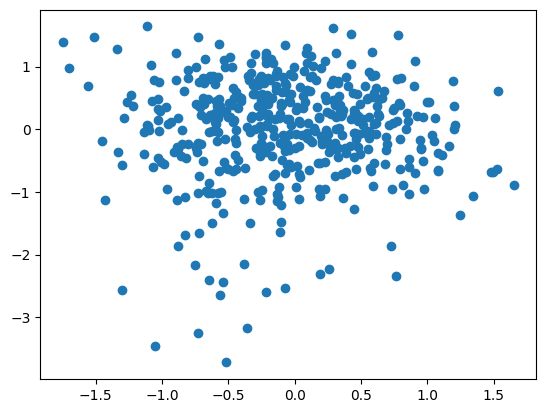

In [6]:
model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]
# model_data = model_data[model_data['t2lv'] < 4]

formula = "thalamus ~ choroid_volume + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()

pred = res.predict(model_data)
plt.scatter(res.fittedvalues, res.resid)
het_breuschpagan(res.resid, res.model.exog)

## Mediation

The effect of thalamus on SDMT is no longer significant when controlling for cortical thickness and t2lv. Both cortical thickness and t2lv are significant, suggesting potential parallel mediation by the two

In [8]:
model_data = df_ms_z.join([df_thomas_z])
model_data.loc[model_data['SDMT'].isna(), 'SDMT'] = model_data['SDMT'].mean()

formula = "SDMT ~ t2lv_logtrans + THALAMUS_1 + cortical_thickness + age + Female + tiv"
res = sm.OLS.from_formula(formula, data=model_data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   SDMT   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     31.15
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           1.96e-31
Time:                        16:41:18   Log-Likelihood:                -577.32
No. Observations:                 468   AIC:                             1169.
Df Residuals:                     461   BIC:                             1198.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0101      0

In [18]:
model_data = df_ms_z.join([df_thomas2_z])
model_data.loc[model_data['SDMT'].isna(), 'SDMT'] = model_data['SDMT'].mean()

p2 = Process(data=model_data, model=4, x="choroid_volume", y="SDMT",
            m=["ventricle_logtrans", "t2lv_logtrans", "cortical_thickness", "THALAMUS_1"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = choroid_volume
    y = SDMT
    m1 = ventricle_logtrans
    m2 = t2lv_logtrans
    m3 = cortical_thickness
    m4 = THALAMUS_1
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = SDMT 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2930   0.2791 0.7008 23.7270    8  458   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons                0.0070 0.0392  0.1795 0.8576 -0.0698  0.0838
choroid_volume      0.0633 0.0566  1.1178 0.2643 -0.0477  0.1742
age        

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [12]:
model_data['brain']

subid
1001    0.517406
1002    3.338861
1003   -1.017700
1004    0.216279
1005   -0.904844
          ...   
3016   -0.677059
3017    0.898435
3021   -1.139559
3023    0.242144
3028    0.707947
Name: brain, Length: 468, dtype: float64

The direct effect of thalamus is significant when including either cortical thickness or t2lv as mediators, but not both. Wallerian degeneration of the thalamus may reflect demyelinating plaques and cortical thinning, which independently contribute to deficits in cognitive processing. 

In [ ]:
p2 = Process(data=model_data, model=4, x="THALAMUS_1", y="SDMT",
            m=["cortical_thickness", "t2lv_logtrans"],
            controls=["age", "Female", "tiv"],
            controls_in="all")

original_stdout = sys.stdout
with open(fig_path / "thalamus_model4_out.txt", 'w') as f:
    sys.stdout = f
    p2.summary()

sys.stdout = original_stdout

# p2.summary()

The effect of choroid volume on SDMT is also mediated by both t2lv and cortical thickness. 

In [10]:
p2 = Process(data=model_data, model=4, x="choroid_volume", y="SDMT",
            m=["t2lv_logtrans", "cortical_thickness", "THALAMUS_1"],
            controls=["age", "Female", "tiv"],
            controls_in="all")

original_stdout = sys.stdout
with open(fig_path / "choroid_model4_out.txt", 'w') as f:
    sys.stdout = f
    p2.summary()

sys.stdout = original_stdout

# p2.summary()

AttributeError: module 'numpy' has no attribute 'product'

## Process Macro

### EDSS

In [7]:
model_data = df_ms_z.join([df_thomas_z])
model_data.loc[model_data['SDMT'].isna(), 'SDMT'] = model_data['SDMT'].median()

# model_data.loc[model_data['SDMT'].isna(), ] = 
p2 = Process(data=model_data, model=7, x="choroid_volume", y="SDMT", w="t2lv_logtrans",
            m=["THALAMUS_1"],
            controls=["age", "Female", "tiv"],
            controls_in="all")

# original_stdout = sys.stdout
# with open(fig_path / "thalamus_model7_out.txt", 'w') as f:
#     sys.stdout = f
#     p2.summary()

# sys.stdout = original_stdout
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = choroid_volume
    y = SDMT
    w = t2lv_logtrans
    m1 = THALAMUS_1
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = SDMT 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2450   0.2351 0.7420 29.9791    5  462   0.0000

Coefficients

                 coeff     se       t      p    LLCI    ULCI
Cons            0.0314 0.0401  0.7830 0.4340 -0.0472  0.1099
choroid_volume -0.0060 0.0501 -0.1207 0.9040 -0.1042  0.0921
age            -0.2276 0.0446 -5.1026 0.0000 -0.3150 -0.1402
Female          0.0

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [ ]:
p2 = Process(data=model_data, model=7, x="t2lv_logtrans", y="EDSS_sqrt", w="choroid_volume",
            m=["cortical_thickness"],
            controls=["age", "Female", "tiv"],
            controls_in="all")

# original_stdout = sys.stdout
# with open(fig_path / "cortical_thickness_model7_out.txt", 'w') as f:
#     sys.stdout = f
#     p2.summary()

# sys.stdout = original_stdout
p2.summary()

In [52]:
from pyprocessmacro import Process

model_data = df_z.copy()
model_data = model_data[model_data['dz_type2'] == "MS"]

p2 = Process(data=model_data, model=7, x="cortical_thickness", y="EDSS_sqrt", w="choroid_volume",
            m=["thalamus"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 7

Variables:
    Cons = Cons
    x = cortical_thickness
    y = EDSS_sqrt
    w = choroid_volume
    m1 = thalamus
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2788   0.2691 0.7452 34.5570    5  447   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons               -0.0190 0.0408 -0.4655 0.6418 -0.0990  0.0610
cortical_thickness -0.0986 0.0565 -1.7451 0.0816 -0.2092  0.0121
age                 0.3153 0.0470  6.7080 0.0000  0.223

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

In [39]:
from pyprocessmacro import Process

model_data = df_z.copy()
model_data = model_data.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

p2 = Process(data=model_data, model=4, x="choroid_volume", y="EDSS_sqrt",
            m=["THALAMUS_1", "cortical_thickness", "t2lv_logtrans"],
            controls=["age", "Female", "tiv"],
            controls_in="all")
p2.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:1567: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  grad = eval_expression(


Process successfully initialized.
Based on the Process Macro by Andrew F. Hayes, Ph.D. (www.afhayes.com)


****************************** SPECIFICATION ****************************

Model = 4

Variables:
    Cons = Cons
    x = choroid_volume
    y = EDSS_sqrt
    m1 = THALAMUS_1
    m2 = cortical_thickness
    m3 = t2lv_logtrans
Statistical Controls:
 age, Female, tiv



Sample size:
468

Bootstrapping information for indirect effects:
Final number of bootstrap samples: 5000
Number of samples discarded due to convergence issues: 0

***************************** OUTCOME MODELS ****************************

Outcome = EDSS_sqrt 
OLS Regression Summary

     R²  Adj. R²    MSE       F  df1  df2  p-value
 0.2866   0.2738 0.7404 25.5418    7  445   0.0000

Coefficients

                     coeff     se       t      p    LLCI    ULCI
Cons               -0.0214 0.0409 -0.5246 0.6001 -0.1015  0.0587
choroid_volume     -0.0726 0.0511 -1.4218 0.1558 -0.1727  0.0275
age                 0.3529 0.

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:738: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_x_to_m = eval_expression(der_x_to_m, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:739: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  expr_m_to_y = eval_expression(der_m_to_y, mod_dict)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmacro/models.py:752: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  llci, ulci = bias_corrected_ci(e, be, conf)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/pyprocessmac

---

In [34]:
model_data = df_z.copy()
model_data = model_data.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]

outcome_model = sm.OLS.from_formula(
    "EDSS_sqrt ~ choroid_volume + cortical_thickness + age + tiv + Female", data=model_data
)
mediator_model = sm.OLS.from_formula(
    "cortical_thickness ~ choroid_volume + age + tiv + Female", data=model_data
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "cortical_thickness"
).fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.072454,0.032592,0.120427,0.000
ACME (treated),0.072454,0.032592,0.120427,0.000
ADE (control),-0.000346,-0.096817,0.100458,0.966
ADE (treated),-0.000346,-0.096817,0.100458,0.966
Total effect,0.072108,-0.024987,0.173202,0.152
Prop. mediated (control),0.900727,-5.956105,8.228081,0.152
Prop. mediated (treated),0.900727,-5.956105,8.228081,0.152
ACME (average),0.072454,0.032592,0.120427,0.000
ADE (average),-0.000346,-0.096817,0.100458,0.966
Prop. mediated (average),0.900727,-5.956105,8.228081,0.152


In [36]:
model_data.to_csv("ms_data_for_process.csv")